# Total mass constraints
Here, we will consider the unbalanced optimal transport under the constraint
$\begin{align}\rho_t(\Omega) = F(t) \end{align}$ 
where $F(t)$ is a prescribed function.

In [4]:
# Import relevant libraries

import math
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from proximal.grids import speed_and_growth
from proximal.dynamicUOT import computeGeodesic
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.animation as animation

# Figure 1: Comaprison with Spherical-Hellinger Kantrovich
The case $F(t) = 1$ is called the spherical Hellinger-Kantrovich distance.

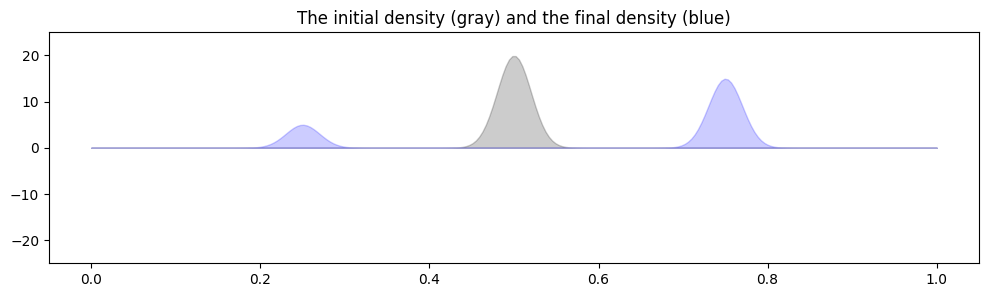

L2 distance between reparametrized distribution and constrained distribution: 0.0038752627748928313


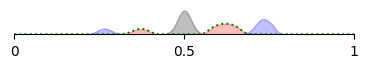

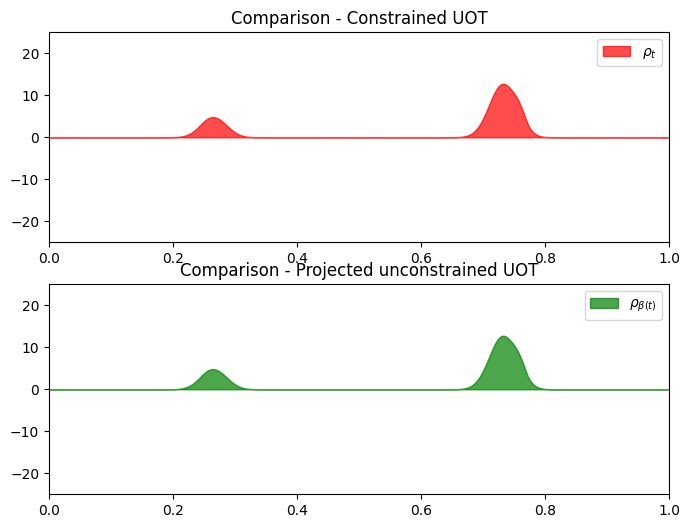

In [59]:
np.random.seed(58)   
def WFR_to_SHK(WFR):
    """ Convert WFR to SHK
    WFR: float, WFR value
    return: float, SHK value"""
    return math.acos(1-WFR**2/4)

def beta(t, SHK, r0, r1):
    """
    Computes the value of β(t) based on the formula.

    Parameters:
    - t (float or np.ndarray): Parameter(s) between 0 and 1.
    - SHK (float): The SHK value.
    - r0 (float): Radius parameter r0.
    - r1 (float): Radius parameter r1.

    Returns:
    - float or np.ndarray: The computed value(s) of β(t).
    """
    t = np.asarray(t)  # Ensure t is a NumPy array
    numerator = r0 * np.sin(t * SHK)
    denominator = r1 * np.sin((1 - t) * SHK) + r0 * np.sin(t * SHK)
    
    # Check for zero denominators
    if np.any(denominator == 0):
        raise ValueError("Denominator in beta(t) calculation is zero for at least one element in t.")
    
    return numerator / denominator

def r(t, SHK, r0, r1):
    """
    Computes the value of r(t) based on the formula.

    Parameters:
    - t (float or np.ndarray): Parameter(s) between 0 and 1.
    - SHK (float): The SHK value.
    - r0 (float): Radius parameter r0.
    - r1 (float): Radius parameter r1.

    Returns:
    - float or np.ndarray: The computed value(s) of r(t).
    """
    t = np.asarray(t)  # Ensure t is a NumPy array
    numerator = r0 * r1 * np.sin(SHK)
    denominator = r1 * np.sin((1 - t) * SHK) + r0 * np.sin(t * SHK)
    
    # Check for zero denominators
    if np.any(denominator == 0):
        raise ValueError("Denominator in r(t) calculation is zero for at least one element in t.")
    
    return numerator / denominator

def reparametrize_mass_distributions(mass_distributions, SHK, r0, r1, cs, ll):
    """
    Reparametrize the mass distributions according to the beta(t) function.

    Parameters:
    - mass_distributions (np.ndarray): Array of shape (time_dim, *space_dims)
    - SHK (float): SHK parameter for beta(t)
    - r0 (float): r0 parameter for beta(t)
    - r1 (float): r1 parameter for beta(t)
    - cs (tuple): the size of the spatial grid
    - ll (tuple): the length of the spatial domain

    Returns:
    - np.ndarray: Reparametrized mass distributions of the same shape.
    """
    time_dim = mass_distributions.shape[0]
    T = time_dim - 1

    # Original time grid
    t = np.linspace(0, 1, time_dim)  # t_i = i / T

    # Compute beta(t_i)
    beta_t = beta(t, SHK, r0, r1)

    # Ensure beta_t is within [0, 1]
    beta_t = np.clip(beta_t, 0, 1)

    # Scale beta_t to index space and find lower indices
    beta_scaled = beta_t * T
    k = np.floor(beta_scaled).astype(int)
    k = np.clip(k, 0, T - 1)  # Ensure indices are within valid range

    # Calculate weights for linear interpolation
    t_k = k / T
    t_k1 = (k + 1) / T
    delta_t = t_k1 - t_k
    delta_t[delta_t == 0] = 1e-10  # Avoid division by zero

    w_k1 = (beta_t - t_k) / delta_t
    w_k = 1 - w_k1

    # Reshape weights for broadcasting
    weight_shape = (time_dim,) + (1,) * (mass_distributions.ndim - 1)
    w_k = w_k.reshape(weight_shape)
    w_k1 = w_k1.reshape(weight_shape)

    # Interpolate mass distributions
    mass_k = mass_distributions[k]
    mass_k1 = mass_distributions[k + 1]

    mass_beta_t = w_k * mass_k + w_k1 * mass_k1
    
    # Normalize for each time step
    reshape = (time_dim,) + (1,) * (mass_beta_t.ndim-1)
    mass_beta_t = (mass_beta_t / np.sum(mass_beta_t, axis=tuple(range(1, mass_beta_t.ndim))).reshape(reshape)) * np.prod(cs[1:]) / np.prod(ll[1:])

    return mass_beta_t

# Define the initial and the terminal distributions
K = 256

# Generate the initial and terminal distributions
X = np.linspace(0, 1, K)  # Discretization of the time-space domain
rho_0 = np.exp(-0.5 * (X-0.5) ** 2 / (0.02 ** 2)) #generate_gaussian_mixture(1, 1.0, K, sigma=0.02, dimension=1)
rho_1 = 0.25 * np.exp(-0.5 * (X-0.25) ** 2 / (0.02 ** 2)) + 0.75 * np.exp(-0.5 * (X-0.75) ** 2 / (0.02 ** 2))
rho_0 /= (np.sum(rho_0) / 255)  # Normalize to make it a density. Our algorithm assumes everything is a density.
rho_1 /= (np.sum(rho_1) / 255)  # Normalize to make it a density. Our algorithm assumes everything is a density.


plt.figure(figsize=(12, 3))
plt.ylim(-25, 25)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2) 
plt.fill_between(X, rho_1, color="b", alpha=0.2)
plt.show()

T = 15
z, lists = computeGeodesic(rho_0, rho_1, T, (1.0, 1.0), niter = 1000)

WFR = np.sqrt(z.V.energy(1.0, 2.0, 2.0))
SHK = WFR_to_SHK(WFR)
r0 = 1.0
r1 = 1.0

# Reparametrize the mass distributions
reparam_D = reparametrize_mass_distributions(z.U.D[0], SHK, r0, r1, (1, K), (1, 1))

# Calculate the constrained geodesic
z, lists = computeGeodesic(rho_0, rho_1, T, (1.0, 1.0), np.ones((T, K)), np.ones(T), niter = 1000)

# -------------------------------------------------------------
# CAMERA‑READY OVERLAY  (constrained + projected t = ½ only)
# -------------------------------------------------------------
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": False})

# frame indices
t0, thalf, t1 = 0, T // 2, T - 1

# -------------------------------------------------------------
# pick a height that hugs the data and cuts everything < 0
# -------------------------------------------------------------
ymax = max(z.U.D[0][[t0, thalf, t1], :].max(),
           reparam_D[thalf, :].max()) * 1.05   # 5 % head‑room

fig, ax = plt.subplots(figsize=(3.5, 0.5))      # ≈ 1‑column figure

# 1️⃣ constrained uOT (filled)
for t, col in zip([t0, thalf, t1], ["k", "r", "b"]):
    ax.fill_between(X, z.U.D[0][t, :],
                    color=col, alpha=0.25)

# 2️⃣ projected uOT  (only t = ½, dotted, green)
ax.plot(X, reparam_D[thalf, :],
        linestyle=":", linewidth=1.4, color="green")

# -------------------------------------------------------------
# cosmetic clean‑up for publication
# -------------------------------------------------------------
ax.set_xlim(0, 1)
ax.set_ylim(0, ymax)                 # → trims the y < 0 whitespace
ax.set_xticks([0, 0.5, 1])
ax.set_xticklabels(["0", "0.5", "1"], fontsize=10)

# remove spines, y‑axis, title, legend
ax.set_yticks([])
for spine in ["left"]:
    ax.spines[spine].set_visible(False)
# top & right are already off in most matplotlib styles; if not:
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

fig.tight_layout(pad=0.05)
fig.savefig("figures/SHK_1D_paper.png", dpi=600,
            bbox_inches="tight", transparent=True)

# -------------------------------------------------------------
# Plotting the video
# -------------------------------------------------------------

# Set up the figure and axes
ylim = [-25, 25]
fig, axs = plt.subplots(2, 1, figsize=[8, 6])

def init():
    # Initialize the plots
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(ylim)
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(ylim)
    return axs

def update(t):
    for ax in axs:
        ax.clear()

    # First subplot for x.U.D
    axs[0].fill_between(X, z.U.D[0][t, :], color="r", alpha=0.7, label=r'$\rho_{t}$')
    axs[0].set_title('Comparison - Constrained UOT')
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(ylim)
    axs[0].legend()

    # Second subplot for reparam_D
    axs[1].fill_between(X, reparam_D[t, :], color="g", alpha=0.7, label=r'$\rho_{\beta(t)}$')
    axs[1].set_title('Comparison - Projected unconstrained UOT')
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(ylim)
    axs[1].legend()

    return axs

ani = animation.FuncAnimation(fig, update, frames=range(T), init_func=init, blit=False)

# Save the animation as an MP4 video
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
ani.save('videos/SHK_1D.mp4', writer=writer)

# Calculate the L2 distance between the reparametrized distribution and the constrained distribution
l2_distance = np.linalg.norm(reparam_D - z.U.D[0], ord=2) * np.sqrt(1 / (K * T)) 
print(f"L2 distance between reparametrized distribution and constrained distribution: {l2_distance}")